# 🛍️ Análise de Dados e Clusterização de Clientes – E-commerce

## 1. Introdução

O objetivo deste projeto é analisar dados de um e-commerce com foco no comportamento de compra dos clientes. A partir dessa análise, busquei identificar padrões, segmentar perfis de clientes e propor estratégias personalizadas de marketing e retenção.

Utilizei técnicas de estatística descritiva, análise multivariada e aprendizado não supervisionado (clusterização), com foco especial na variável `Review Rating` (avaliação do cliente).

As etapas incluem:

- Exploração e visualização dos dados.
- Avaliação de correlações e variáveis relevantes.
- Construção de "superfeatures" para ganho de explicabilidade.
- Clusterização de clientes baseada em padrões de comportamento.
- Estratégias de negócio baseadas nos clusters.

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from cycler import cycler
from pandas.api.types import CategoricalDtype

from itertools import combinations
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

from src.avaliacao_grupo import avaliar_grupo
from src.clusters import clusterizar_clientes
from src.clusters_perfis import gerar_perfis_clusters
from src.estatistica import tabela_distribuicao_frequencias
from src.estatistica import composicao_histograma_boxplot
from src.superfeature import avaliar_superfeature
from src.superfeature_diagnostico import diagnostico_superfeature

# Definição das paletas de cores
cores = plt.get_cmap('Accent').colors
ciclo_cores = cycler('color', cores)
plt.rc('axes', prop_cycle=ciclo_cores)

DADOS = r"C:\Users\Camilo_Bica\data_science\portifolio/customer_shopping/dados/shopping_trends_updated.csv"

df_customer = pd.read_csv(DADOS)

df_customer.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


## 2. Exploração dos Dados

### 2.1 Leitura do Dataset

O dataset contém informações transacionais e demográficas de clientes. Excluí o identificador `Customer ID` por não ter valor analítico.

### 2.2 Visão Geral

Utilizei `.info()` e `.describe()` para entender a estrutura e os valores das colunas, além de identificar tipos de dados, valores ausentes e outliers.

### 2.3 Análise Visual Inicial

Boxplots foram gerados para as variáveis numéricas (`Age`, `Purchase Amount`, `Review Rating`, `Previous Purchases`) com o objetivo de identificar a distribuição e possíveis valores extremos.

Essa etapa é fundamental para orientar os próximos passos de modelagem estatística e pré-processamento.

In [2]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

In [3]:
df_customer = df_customer.drop(["Customer ID"], axis=1)

In [4]:
with pd.option_context("float_format", "{:.2f}".format):
    display(df_customer.describe())

,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.00,3900.00,3900.00,3900.00
mean,44.07,59.76,3.75,25.35
std,15.21,23.69,0.72,14.45
min,18.00,20.00,2.50,1.00
25%,31.00,39.00,3.10,13.00
50%,44.00,60.00,3.70,25.00
75%,57.00,81.00,4.40,38.00
max,70.00,100.00,5.00,50.00


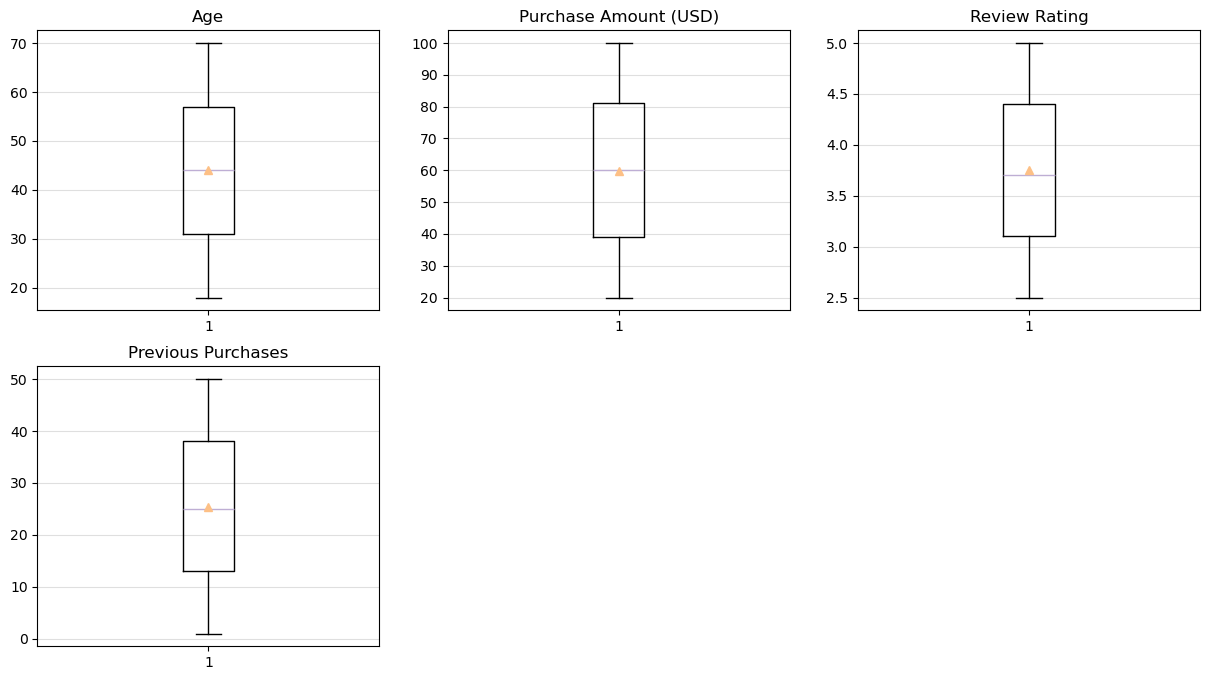

In [5]:
plt.figure(figsize=(15, 8))
for i, coluna in enumerate(["Age", "Purchase Amount (USD)", "Review Rating", "Previous Purchases"]):
    plt.subplot(2, 3, i + 1) 
    plt.boxplot(df_customer[coluna], showmeans=True)
    plt.title(coluna)
    plt.grid(axis='y', alpha=0.4)

plt.savefig(r"C:\Users\Camilo_Bica\data_science\portifolio\customer_shopping\imagens\boxplot_inicial.png", dpi=200, bbox_inches='tight')

plt.show()

In [6]:
df_customer.describe(exclude="number")

,Gender,Item Purchased,Category,Location,Size,Color,Season,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Payment Method,Frequency of Purchases
count,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900
unique,2,25,4,50,4,25,4,2,6,2,2,6,7
top,Male,Blouse,Clothing,Montana,M,Olive,Spring,No,Free Shipping,No,No,PayPal,Every 3 Months
freq,2652,171,1737,96,1755,177,999,2847,675,2223,2223,677,584


In [7]:
df_customer = df_customer.drop(["Promo Code Used"], axis=1)

In [8]:
cols = ["Discount Applied", "Subscription Status"] 

df_customer[cols] = df_customer[cols].replace({"Yes": 1, "No": 0})

C:\Users\Camilo_Bica\AppData\Local\Temp\ipykernel_12612\4288747498.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_customer[cols] = df_customer[cols].replace({"Yes": 1, "No": 0})


In [9]:
colunas_categoricas_nao_ordenadas = [
    "Gender",
    "Item Purchased",
    "Category",
    "Location",
    "Color",
    "Shipping Type",
    "Payment Method",
    "Discount Applied",
    "Subscription Status"
]

colunas_categoricas_ordenadas = [
    "Size",
    "Season",
    "Frequency of Purchases"
]

coluna_alvo = ["Review Rating"]

colunas_numericas = [
    coluna for coluna in df_customer.columns if coluna not in (
        colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas + coluna_alvo
    )
]

In [10]:
for coluna in (colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas):
    print(f"{coluna}: {df_customer[coluna].unique()}")

Gender: ['Male' 'Female']
Item Purchased: ['Blouse' 'Sweater' 'Jeans' 'Sandals' 'Sneakers' 'Shirt' 'Shorts' 'Coat'
 'Handbag' 'Shoes' 'Dress' 'Skirt' 'Sunglasses' 'Pants' 'Jacket' 'Hoodie'
 'Jewelry' 'T-shirt' 'Scarf' 'Hat' 'Socks' 'Backpack' 'Belt' 'Boots'
 'Gloves']
Category: ['Clothing' 'Footwear' 'Outerwear' 'Accessories']
Location: ['Kentucky' 'Maine' 'Massachusetts' 'Rhode Island' 'Oregon' 'Wyoming'
 'Montana' 'Louisiana' 'West Virginia' 'Missouri' 'Arkansas' 'Hawaii'
 'Delaware' 'New Hampshire' 'New York' 'Alabama' 'Mississippi'
 'North Carolina' 'California' 'Oklahoma' 'Florida' 'Texas' 'Nevada'
 'Kansas' 'Colorado' 'North Dakota' 'Illinois' 'Indiana' 'Arizona'
 'Alaska' 'Tennessee' 'Ohio' 'New Jersey' 'Maryland' 'Vermont'
 'New Mexico' 'South Carolina' 'Idaho' 'Pennsylvania' 'Connecticut' 'Utah'
 'Virginia' 'Georgia' 'Nebraska' 'Iowa' 'South Dakota' 'Minnesota'
 'Washington' 'Wisconsin' 'Michigan']
Color: ['Gray' 'Maroon' 'Turquoise' 'White' 'Charcoal' 'Silver' 'Pink' 'Purple'

In [11]:
for coluna in colunas_categoricas_nao_ordenadas:
    df_customer[coluna] = df_customer[coluna].astype("category")

for coluna in colunas_categoricas_ordenadas:
    df_customer[coluna] = df_customer[coluna].astype("category")

    categorias_ordenadas = sorted(df_customer[coluna].unique())

    df_customer[coluna] = df_customer[coluna].cat.set_categories(categorias_ordenadas, ordered=True)

df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Age                     3900 non-null   int64   
 1   Gender                  3900 non-null   category
 2   Item Purchased          3900 non-null   category
 3   Category                3900 non-null   category
 4   Purchase Amount (USD)   3900 non-null   int64   
 5   Location                3900 non-null   category
 6   Size                    3900 non-null   category
 7   Color                   3900 non-null   category
 8   Season                  3900 non-null   category
 9   Review Rating           3900 non-null   float64 
 10  Subscription Status     3900 non-null   category
 11  Shipping Type           3900 non-null   category
 12  Discount Applied        3900 non-null   category
 13  Previous Purchases      3900 non-null   int64   
 14  Payment Method          

In [12]:
# Definir a ordem correta das categorias
size_order = CategoricalDtype(['S', 'M', 'L', 'XL'], ordered=True)
season_order = CategoricalDtype(['Winter', 'Spring', 'Summer', 'Fall'], ordered=True)
frequency_order = CategoricalDtype(['Weekly', 'Bi-Weekly', 'Quarterly', 'Fortnightly', 'Monthly', 'Every 3 Months', 'Annually'], ordered=True)

# Aplicar a nova ordem das categorias no df_customer
df_customer['Size'] = df_customer['Size'].astype(size_order)
df_customer['Season'] = df_customer['Season'].astype(season_order)
df_customer['Frequency of Purchases'] = df_customer['Frequency of Purchases'].astype(frequency_order)

In [13]:
for coluna in (colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas):
    print(f"{coluna}: {df_customer[coluna].unique()}")
    print()

Gender: ['Male', 'Female']
Categories (2, object): ['Female', 'Male']

Item Purchased: ['Blouse', 'Sweater', 'Jeans', 'Sandals', 'Sneakers', ..., 'Socks', 'Backpack', 'Belt', 'Boots', 'Gloves']
Length: 25
Categories (25, object): ['Backpack', 'Belt', 'Blouse', 'Boots', ..., 'Socks', 'Sunglasses', 'Sweater', 'T-shirt']

Category: ['Clothing', 'Footwear', 'Outerwear', 'Accessories']
Categories (4, object): ['Accessories', 'Clothing', 'Footwear', 'Outerwear']

Location: ['Kentucky', 'Maine', 'Massachusetts', 'Rhode Island', 'Oregon', ..., 'South Dakota', 'Minnesota', 'Washington', 'Wisconsin', 'Michigan']
Length: 50
Categories (50, object): ['Alabama', 'Alaska', 'Arizona', 'Arkansas', ..., 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

Color: ['Gray', 'Maroon', 'Turquoise', 'White', 'Charcoal', ..., 'Orange', 'Indigo', 'Yellow', 'Magenta', 'Blue']
Length: 25
Categories (25, object): ['Beige', 'Black', 'Blue', 'Brown', ..., 'Turquoise', 'Violet', 'White', 'Yellow']

Shipping Type:

In [14]:
bins_age = np.histogram_bin_edges(df_customer["Age"], bins="sturges")

bins_age

array([18., 22., 26., 30., 34., 38., 42., 46., 50., 54., 58., 62., 66.,
       70.])

In [15]:
labels_age = [f"({int(bins_age[i])}, {int(bins_age[i+1])}]" for i in range(len(bins_age)-1)]

df_age_intervalos =  pd.cut(
    df_customer["Age"], 
    bins=bins_age, 
    labels=labels_age,
    right=True,
    include_lowest=True
).value_counts().sort_index().to_frame()

df_age_intervalos

,count
Age,
"(18, 22]",347
"(22, 26]",293
"(26, 30]",309
"(30, 34]",292
"(34, 38]",293
"(38, 42]",306
"(42, 46]",278
"(46, 50]",306
"(50, 54]",298


In [16]:
df_customer["Age Interval"] = pd.cut(
    df_customer["Age"], 
    bins=bins_age, 
    labels=labels_age,
    right=True,
    include_lowest=True
)

In [17]:
bins_review = np.array([2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
labels_review = ['[2.5, 3.0]', '(3.0, 3.5]', '(3.5, 4.0]', '(4.0, 4.5]', '(4.5, 5.0]']

In [18]:
df_review_intervalos =  pd.cut(
    df_customer["Review Rating"], 
    bins=bins_review, 
    labels=labels_review,
    right=True,
    include_lowest=True
).value_counts().sort_index().to_frame()

df_review_intervalos

,count
Review Rating,
"[2.5, 3.0]",847
"(3.0, 3.5]",799
"(3.5, 4.0]",791
"(4.0, 4.5]",763
"(4.5, 5.0]",700


In [19]:
df_customer["Review Interval"] = pd.cut(
    df_customer["Review Rating"], 
    bins=bins_review, 
    labels=labels_review,
    right=True,
    include_lowest=True
)

df_customer

,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Previous Purchases,Payment Method,Frequency of Purchases,Age Interval,Review Interval
0,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,1,Express,1,14,Venmo,Fortnightly,"(54, 58]","(3.0, 3.5]"
1,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,1,Express,1,2,Cash,Fortnightly,"(18, 22]","(3.0, 3.5]"
2,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,1,Free Shipping,1,23,Credit Card,Weekly,"(46, 50]","(3.0, 3.5]"
3,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,1,Next Day Air,1,49,PayPal,Weekly,"(18, 22]","(3.0, 3.5]"
4,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,1,Free Shipping,1,31,PayPal,Annually,"(42, 46]","[2.5, 3.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,40,Female,Hoodie,Clothing,28,Virginia,L,Turquoise,Summer,4.2,0,2-Day Shipping,0,32,Venmo,Weekly,"(38, 42]","(4.0, 4.5]"
3896,52,Female,Backpack,Accessories,49,Iowa,L,White,Spring,4.5,0,Store Pickup,0,41,Bank Transfer,Bi-Weekly,"(50, 54]","(4.0, 4.5]"
3897,46,Female,Belt,Accessories,33,New Jersey,L,Green,Spring,2.9,0,Standard,0,24,Venmo,Quarterly,"(42, 46]","[2.5, 3.0]"
3898,44,Female,Shoes,Footwear,77,Minnesota,S,Brown,Summer,3.8,0,Express,0,24,Venmo,Weekly,"(42, 46]","(3.5, 4.0]"


In [20]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Age                     3900 non-null   int64   
 1   Gender                  3900 non-null   category
 2   Item Purchased          3900 non-null   category
 3   Category                3900 non-null   category
 4   Purchase Amount (USD)   3900 non-null   int64   
 5   Location                3900 non-null   category
 6   Size                    3900 non-null   category
 7   Color                   3900 non-null   category
 8   Season                  3900 non-null   category
 9   Review Rating           3900 non-null   float64 
 10  Subscription Status     3900 non-null   category
 11  Shipping Type           3900 non-null   category
 12  Discount Applied        3900 non-null   category
 13  Previous Purchases      3900 non-null   int64   
 14  Payment Method          

In [21]:
df_customer.isnull().sum()

Age                       0
Gender                    0
Item Purchased            0
Category                  0
Purchase Amount (USD)     0
Location                  0
Size                      0
Color                     0
Season                    0
Review Rating             0
Subscription Status       0
Shipping Type             0
Discount Applied          0
Previous Purchases        0
Payment Method            0
Frequency of Purchases    0
Age Interval              0
Review Interval           0
dtype: int64

In [22]:
df_customer.to_csv(r"C:\Users\Camilo_Bica\data_science\portifolio/customer_shopping/dados/shopping_trends_tratado.csv", index=False)

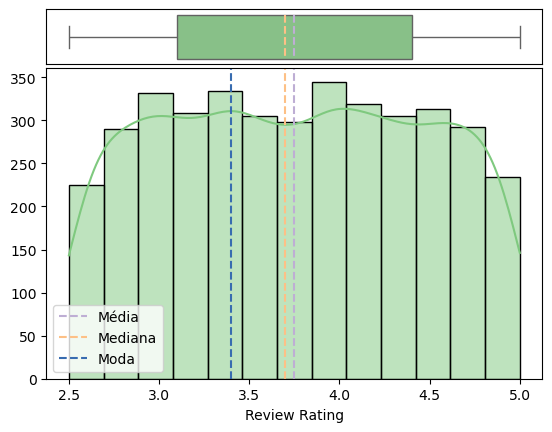

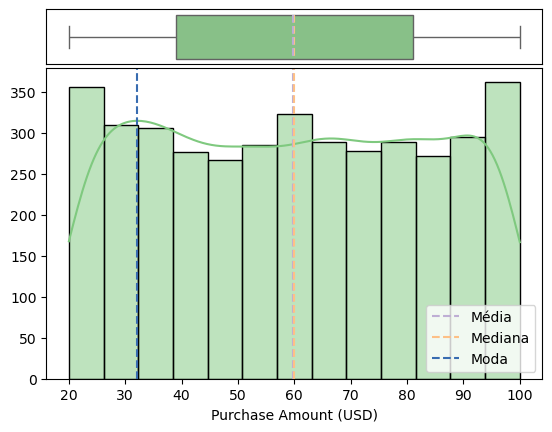

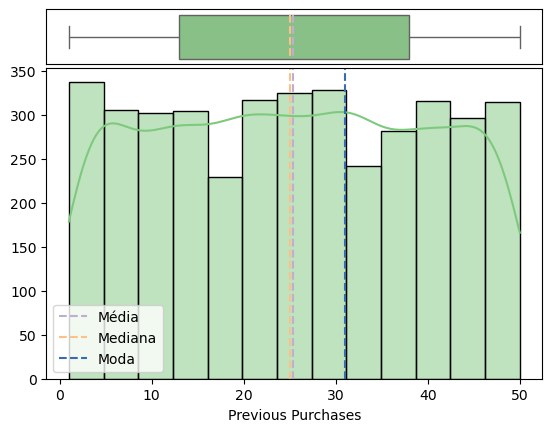

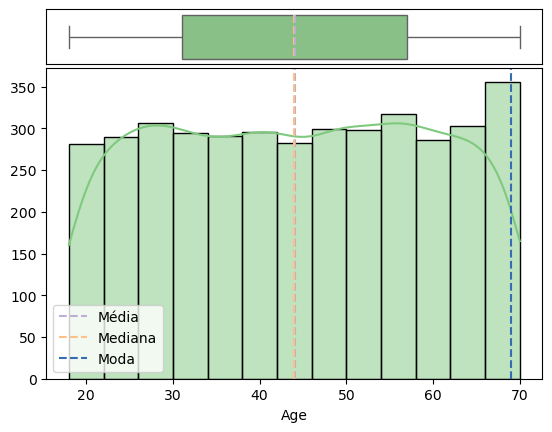

In [23]:
cols = ["Review Rating", "Purchase Amount (USD)", "Previous Purchases", "Age"]

for col in cols:
    composicao_histograma_boxplot(df_customer, col)

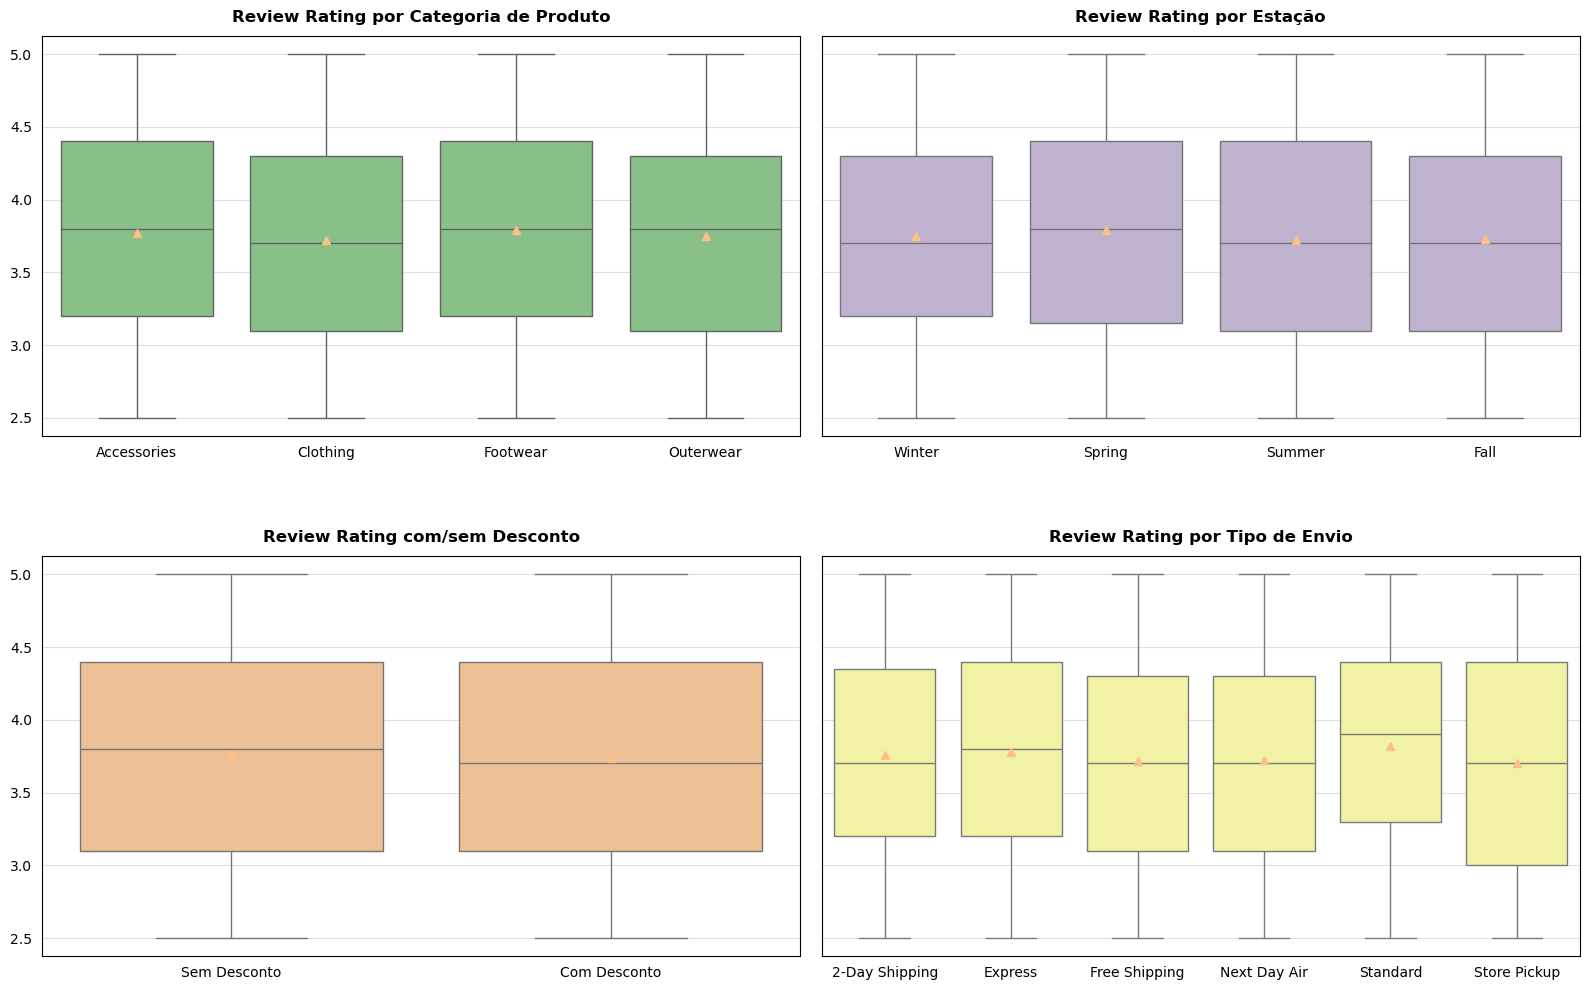

In [24]:
# Aplicar cor individualmente aos boxplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.boxplot(x="Category", y="Review Rating", data=df_customer, ax=axes[0, 0], color=cores[0], showmeans=True)
axes[0, 0].set_title("Review Rating por Categoria de Produto", fontsize=12, weight='bold', pad=10)
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('')
axes[0, 0].grid(axis='y', alpha=0.4)
axes[0, 0].tick_params(left=False, bottom=False)

sns.boxplot(x="Season", y="Review Rating", data=df_customer, ax=axes[0, 1], color=cores[1], showmeans=True)
axes[0, 1].set_title("Review Rating por Estação", fontsize=12, weight='bold', pad=10)
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].tick_params(labelleft=False, left=False, bottom=False)
axes[0, 1].grid(axis='y', alpha=0.4)

sns.boxplot(x="Discount Applied", y="Review Rating", data=df_customer, ax=axes[1, 0], color=cores[2], showmeans=True)
axes[1, 0].set_title("Review Rating com/sem Desconto", fontsize=12, weight='bold', pad=10)
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(["Sem Desconto", "Com Desconto"])
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('')
axes[1, 0].grid(axis='y', alpha=0.4)
axes[1, 0].tick_params(left=False, bottom=False)

sns.boxplot(x="Shipping Type", y="Review Rating", data=df_customer, ax=axes[1, 1], color=cores[3], showmeans=True)
axes[1, 1].set_title("Review Rating por Tipo de Envio", fontsize=12, weight='bold', pad=10)
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('')
axes[1, 1].tick_params(labelleft=False, left=False, bottom=False)
axes[1, 1].grid(axis='y', alpha=0.4)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

plt.savefig(r"C:\Users\Camilo_Bica\data_science\portifolio\customer_shopping\imagens\boxplot_review_rating_categoria.png", dpi=200, bbox_inches='tight')
plt.show()

## 3. Análise Estatística

### 3.1 Correlação entre Variáveis

Analisei as correlações entre `Review Rating` e outras variáveis numéricas. O resultado sugere **baixa correlação**, indicando que esses atributos explicam pouco sobre a avaliação dada pelo cliente.

### 3.2 Testes ANOVA

Executei testes de hipótese para verificar se variáveis categóricas impactam significativamente a avaliação (`Review Rating`). Aqui, explorei o uso de ANOVA para comparar médias entre grupos.

Conclusão: Variáveis categóricas parecem ter maior poder explicativo do que as variáveis numéricas isoladas.

### 3.3 Interpretação Crítica

As notas de avaliação podem ser fortemente influenciadas por fatores **subjetivos não registrados**, como:

- Qualidade percebida
- Atendimento recebido
- Expectativa vs realidade

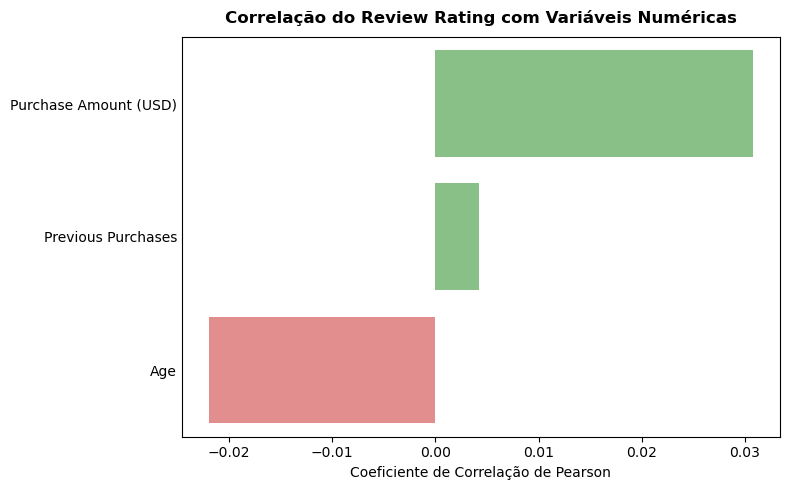

Purchase Amount (USD)    0.030776
Previous Purchases       0.004229
Age                     -0.021949
Name: Review Rating, dtype: float64

<Figure size 640x480 with 0 Axes>

In [25]:
colunas_numericas_sem_id = ["Purchase Amount (USD)", "Previous Purchases", "Age", "Review Rating"]

# Calcular correlação de Pearson entre Review Rating e as demais variáveis numéricas
correlacao_matrix = df_customer[colunas_numericas_sem_id].corr()

# Extrair correlação específica com Review Rating
review_corr = correlacao_matrix["Review Rating"].drop("Review Rating").sort_values(ascending=False)

paleta_cores = [cores[0] if idx != 'Age' else 'lightcoral' for idx in review_corr.index]

# Plotar
plt.figure(figsize=(8, 5))
sns.barplot(
    x=review_corr.values,
    y=review_corr.index,
    hue=review_corr.index,  # define 'hue' para cada barra
    palette=paleta_cores,
    legend=False  # evita mostrar uma legenda desnecessária
)
plt.title("Correlação do Review Rating com Variáveis Numéricas", fontsize=12, weight='bold', pad=10)
plt.xlabel("Coeficiente de Correlação de Pearson")
plt.ylabel('')
plt.tick_params(axis='y', length=0)
plt.tight_layout()
plt.grid(False)
plt.show()

plt.savefig(r"C:\Users\Camilo_Bica\data_science\portifolio\customer_shopping\imagens\correlacao_review_rating.png", dpi=200, bbox_inches='tight')

review_corr

As variáveis numéricas por si só não explicam bem a variação nas notas de avaliação. Aparentemente, os fatores mais relevantes devem estar nas variáveis categóricas, como tipo de envio, categoria, ou fatores qualitativos subjetivos.

In [26]:
# Junta todas as variáveis categóricas (ordenadas e não ordenadas)
colunas_categoricas = colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas

# Função para ANOVA
def anova_test(df, target, category):
    grupos = [grupo[target].values for _, grupo in df.groupby(category, observed=True)]
    stat, p_value = f_oneway(*grupos)
    return category, p_value

# Executar ANOVA para cada variável categórica
resultados = [anova_test(df_customer, coluna_alvo[0], cat) for cat in colunas_categoricas]

# Exibir os resultados
df_anova = pd.DataFrame(resultados, columns=["Variável", "p-valor"])
df_anova["Significativo (α=0.05)"] = df_anova["p-valor"] < 0.05
df_anova = df_anova.sort_values("p-valor")

display(df_anova)

,Variável,p-valor,Significativo (α=0.05)
4,Color,0.011263,True
5,Shipping Type,0.038365,True
9,Size,0.043155,True
2,Category,0.156579,False
10,Season,0.165698,False
7,Discount Applied,0.435678,False
6,Payment Method,0.503791,False
0,Gender,0.610280,False
8,Subscription Status,0.690954,False
1,Item Purchased,0.699632,False


R²: -0.038058441297103895
MAE: 0.6560724024644656
RMSE: 0.7523378907952646


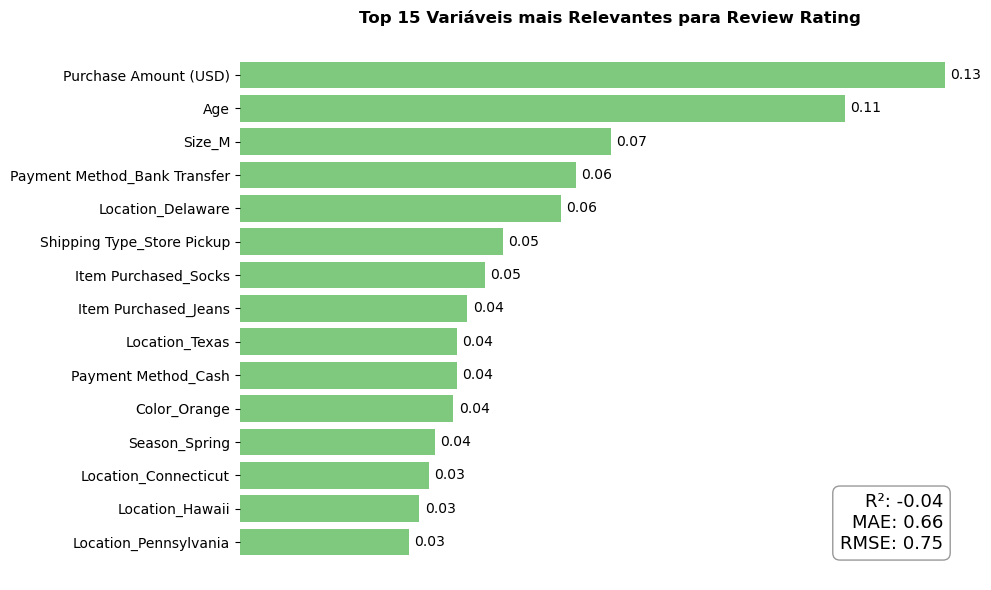

In [27]:
# Define X (features) e y (target)
X = df_customer[colunas_numericas + colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas]
y = df_customer[coluna_alvo[0]]

# Pré-processamento: OneHotEncoding para variáveis categóricas
categorical_cols = colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas
numeric_cols = colunas_numericas

preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
], remainder="passthrough")  # Deixa variáveis numéricas como estão

# Pipeline com árvore de decisão
pipeline = Pipeline(steps=[
    ("preprocessamento", preprocessor),
    ("modelo", DecisionTreeRegressor(random_state=42, max_depth=5))  # max_depth para facilitar visualização
])

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar modelo
pipeline.fit(X_train, y_train)

# Prever
y_pred = pipeline.predict(X_test)

# Avaliação
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

rmse = root_mean_squared_error(y_test, y_pred)
print("RMSE:", rmse)

# Importância das variáveis
modelo = pipeline.named_steps["modelo"]
ohe = pipeline.named_steps["preprocessamento"].named_transformers_["cat"]
feature_names = ohe.get_feature_names_out(categorical_cols).tolist() + numeric_cols
importancias = modelo.feature_importances_

# Top variáveis
df_importancia = pd.DataFrame({"Feature": feature_names, "Importância": importancias})
df_importancia = df_importancia.sort_values("Importância", ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_importancia["Feature"], df_importancia["Importância"])
plt.title("Top 15 Variáveis mais Relevantes para Review Rating", fontsize=12, weight='bold', pad=10)
plt.xticks([])
plt.grid(False)
plt.gca().invert_yaxis()

for spine in ["top", "right", "left", "bottom"]:
    plt.gca().spines[spine].set_visible(False)

# Adiciona os valores na ponta de cada barra
for i, (valor, nome) in enumerate(zip(df_importancia["Importância"], df_importancia["Feature"])):
    plt.text(valor + 0.001, i, f"{valor:.2f}", va='center')

# Texto com métricas de avaliação
metrics_text = f"R²: {r2_score(y_test, y_pred):.2f}\nMAE: {mean_absolute_error(y_test, y_pred):.2f}\nRMSE: {rmse:.2f}"

# Adiciona o texto no gráfico (coordenadas em eixos)
plt.gca().text(
    0.95, 0.05,                # posição (x, y) em coordenadas relativas ao eixo
    metrics_text,
    transform=plt.gca().transAxes,
    fontsize=13,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="gray", alpha=0.8)
)

plt.savefig(r"C:\Users\Camilo_Bica\data_science\portifolio\customer_shopping\imagens\top_15_variaveis_relevantes_review.png", dpi=200, bbox_inches='tight')

plt.tight_layout()
plt.show()

### Importâncias baixas (todas < 0.15)

Mesmo a variável mais importante contribui só com 13% da decisão da árvore.

Isso sugere que o modelo tem baixa capacidade preditiva para Review Rating com os dados atuais.

Provavelmente, a avaliação (Review Rating) é influenciada por fatores não disponíveis no dataset:

- Experiência subjetiva do cliente
- Atendimento
- Expectativa vs realidade
- Qualidade percebida, etc.

O modelo mostra que nenhuma variável sozinha tem grande poder de explicação sobre a nota `Review Rating`. A previsão da nota é limitada pelos dados disponíveis e, provavelmente, depende de fatores qualitativos externos não registrados no dataset.

In [28]:
# Define X e y
X = df_customer[colunas_numericas + colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas]
y = df_customer[coluna_alvo[0]]

# Separar treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pré-processador
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas)
], remainder="passthrough")

# Modelos a comparar
modelos = {
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Treinar, prever e avaliar cada modelo
resultados = []
for nome, modelo in modelos.items():
    pipeline = Pipeline([
        ("preprocessamento", preprocessor),
        ("modelo", modelo)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    resultados.append({"Modelo": nome, "R²": r2, "MAE": mae})

# Mostrar resultados
df_resultados = pd.DataFrame(resultados).sort_values("R²", ascending=False)

display(df_resultados)

,Modelo,R²,MAE
3,Gradient Boosting,-0.010077,0.645451
1,Random Forest,-0.017538,0.646235
2,Linear Regression,-0.035554,0.652533
0,Decision Tree,-0.038058,0.656072


## 4. Clusterização de Clientes

### 4.1 Pré-processamento

Utilizei pipelines com `OneHotEncoder` e `StandardScaler` para tratar variáveis categóricas e normalizar os dados numéricos, preparando-os para a clusterização.

### 4.2 Redução Dimensional com PCA

Reduzi a dimensionalidade usando PCA para facilitar a visualização dos clusters e mitigar ruído de alta dimensionalidade.

### 4.3 Aplicação do KMeans

O algoritmo KMeans foi usado para segmentar os clientes em grupos com características semelhantes. O número ideal de clusters foi escolhido com base em critérios como a inércia e a visualização da separação via PCA.

### 4.4 Visualização dos Clusters

Os clusters foram visualizados em um gráfico 2D, com destaque para as diferenças de comportamento entre os grupos.

### 4.5 Perfil dos Clusters

Criei perfis descritivos para cada cluster, utilizando estatísticas médias das variáveis. Isso permite compreender quem são os clientes de cada grupo e como eles se diferenciam.

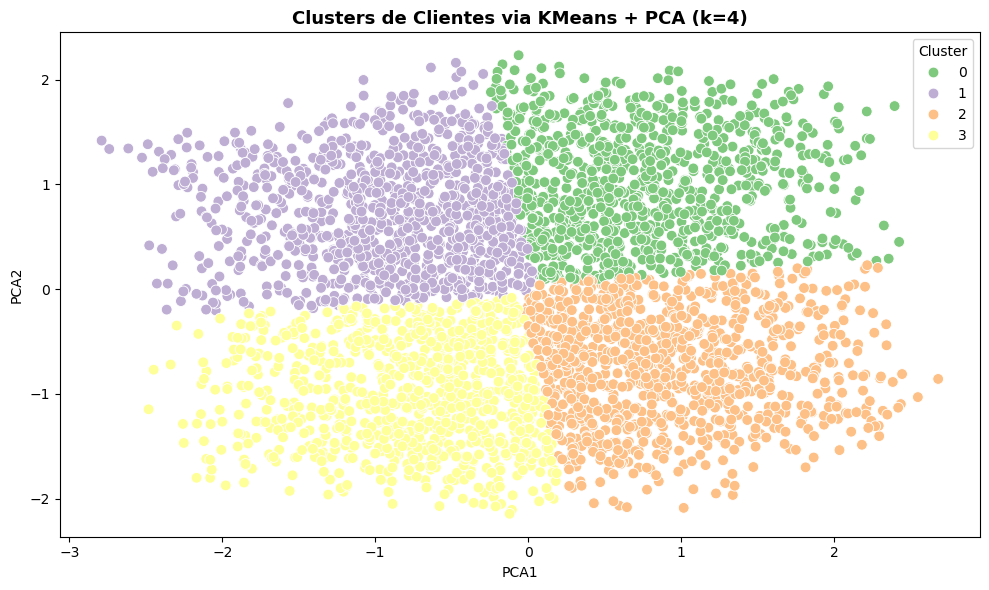

Silhouette Score: 0.367


,Media_Review_Rating,Quantidade
Cluster,,
0,3.793140,933
1,3.778537,1025
2,3.688748,1022
3,3.742283,920


In [29]:
df_clusterizado, modelo_cluster = clusterizar_clientes(
    df=df_customer,
    colunas_numericas=colunas_numericas,
    colunas_categoricas_ordenadas=colunas_categoricas_ordenadas,
    colunas_categoricas_nao_ordenadas=colunas_categoricas_nao_ordenadas,
    n_clusters=4
)

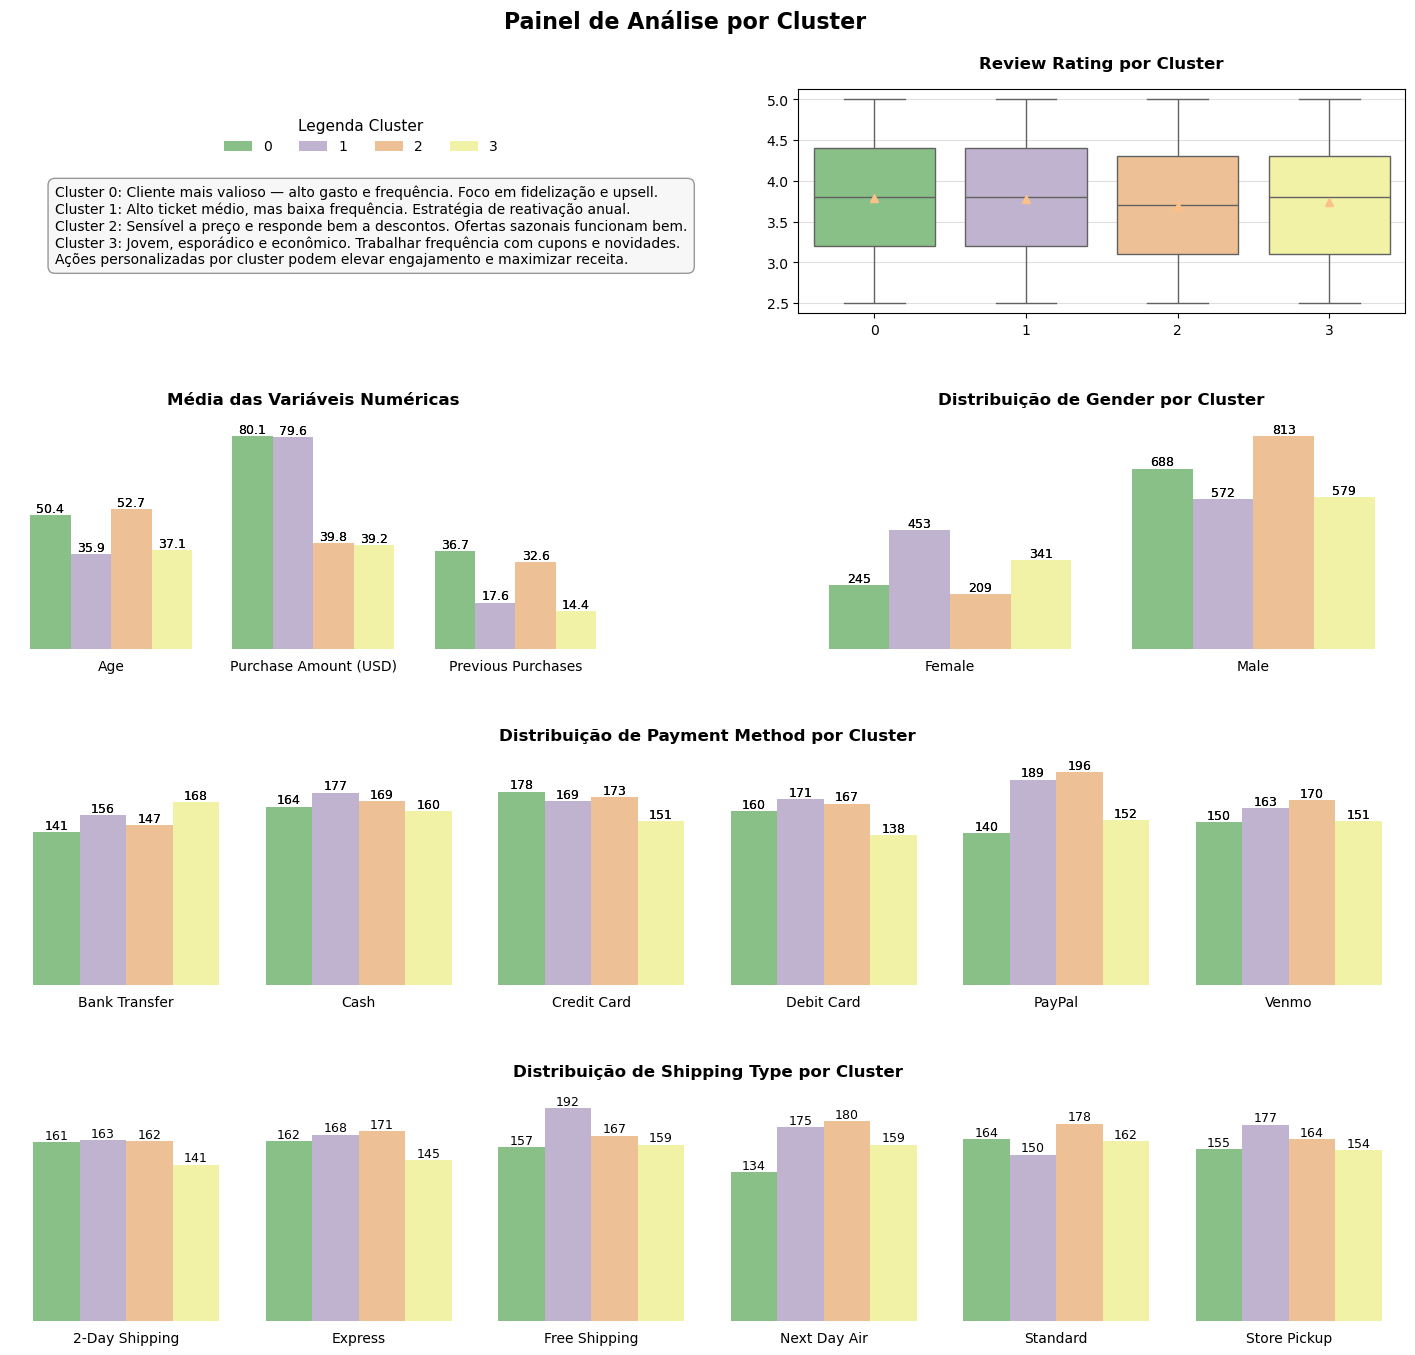

In [30]:
# Layout do mosaico
mosaico = ".A;BC;DD;EE"
fig = plt.figure(figsize=(18, 16))
espacamento = {'wspace': 0.3, 'hspace': 0.5}
axs = fig.subplot_mosaic(mosaico, gridspec_kw=espacamento)


# ====== A: Boxplot Review Rating ======
sns.boxplot(
    data=df_clusterizado,
    x="Cluster",
    y="Review Rating",
    hue="Cluster",
    palette="Accent",
    ax=axs['A'],
    legend=False,
    showmeans=True
)
axs['A'].set_title("Review Rating por Cluster", fontsize=12, weight='bold', pad=15)
axs['A'].set_xlabel("")
axs['A'].set_ylabel("")
axs['A'].grid(axis='y', alpha=0.4)


# ====== B: Médias numéricas (com seaborn) ======
media_numerica = df_clusterizado.groupby("Cluster")[colunas_numericas].mean()
media_melted = media_numerica.T.reset_index().melt(id_vars="index", var_name="Cluster", value_name="Média")
media_melted.rename(columns={"index": "Variável"}, inplace=True)

sns.barplot(
    data=media_melted,
    x="Variável",
    y="Média",
    hue="Cluster",
    palette="Accent",
    ax=axs['B']
)
axs['B'].set_title("Média das Variáveis Numéricas", fontsize=12, weight='bold', pad=15)
axs['B'].set_xlabel("")
axs['B'].set_ylabel("")
axs['B'].legend(title="Cluster")
axs['B'].grid(False)

# Captura os handles e labels da legenda do gráfico B
legend_handles, legend_labels = axs['B'].get_legend_handles_labels()
axs['B'].legend_.remove()

for container in axs['B'].containers:
    axs['B'].bar_label(container, fmt="%.1f", label_type="edge", fontsize=9)

for spine in axs['B'].spines.values():
    spine.set_visible(False)


# ====== C: Gender ======
sns.countplot(data=df_clusterizado, x="Gender", hue="Cluster", palette="Accent", ax=axs['C'])
axs['C'].set_title("Distribuição de Gender por Cluster", fontsize=12, weight='bold', pad=15)
axs['C'].set_xlabel("")
axs['C'].set_ylabel("")
axs['C'].grid(False)

for container in axs['C'].containers:
    axs['C'].bar_label(container, fmt="%d", label_type="edge", fontsize=9)

for spine in axs['C'].spines.values():
    spine.set_visible(False)


# ====== D: Payment Method ======
sns.countplot(data=df_clusterizado, x="Payment Method", hue="Cluster", palette="Accent", ax=axs['D'])
axs['D'].set_title("Distribuição de Payment Method por Cluster", fontsize=12, weight='bold', pad=15)
axs['D'].set_xlabel("")
axs['D'].set_ylabel("")
axs['D'].tick_params(axis='x')
axs['D'].grid(False)

for container in axs['D'].containers:
    axs['D'].bar_label(container, fmt="%d", label_type="edge", fontsize=9)

for spine in axs['D'].spines.values():
    spine.set_visible(False)


# ====== E: Shipping Type ======
sns.countplot(data=df_clusterizado, x="Shipping Type", hue="Cluster", palette="Accent", ax=axs['E'])
axs['E'].set_title("Distribuição de Shipping Type por Cluster", fontsize=12, weight='bold', pad=15)
axs['E'].set_xlabel("")
axs['E'].set_ylabel("")
axs['E'].grid(False)


# ====== Ajustes no Layout dos gráficos ======
for ax_key in ['B', 'C', 'D', 'E']:
    ax = axs[ax_key]
    ax.set_ylabel("")
    ax.tick_params(axis='y', left=False, labelleft=False)  # tira do Y
    ax.tick_params(axis='x', bottom=False)                 # tira do X (se quiser)
    for spine in ax.spines.values():
        spine.set_visible(False)
    for container in ax.containers:
        fmt = "%.1f" if ax_key == "B" else "%d"
        ax.bar_label(container, fmt=fmt, label_type="edge", fontsize=9)


# ====== Legenda horizontal centralizada entre a linha de cima e a de baixo ======
fig.legend(
    legend_handles,
    legend_labels,
    loc='upper center',
    bbox_to_anchor=(0.32, 0.87),  # ajuste fino vertical
    ncol=len(legend_labels),     # exibe todos em linha
    title='Legenda Cluster',
    frameon=False,
    fontsize=10,
    title_fontsize=11
)

for ax_key in ['C', 'D', 'E']:
    axs[ax_key].legend_.remove()

insights = (
    "Cluster 0: Cliente mais valioso — alto gasto e frequência. Foco em fidelização e upsell.\n"
    "Cluster 1: Alto ticket médio, mas baixa frequência. Estratégia de reativação anual.\n"
    "Cluster 2: Sensível a preço e responde bem a descontos. Ofertas sazonais funcionam bem.\n"
    "Cluster 3: Jovem, esporádico e econômico. Trabalhar frequência com cupons e novidades.\n"
    "Ações personalizadas por cluster podem elevar engajamento e maximizar receita."
)

# ====== Caixa de insights abaixo da legenda ======
fig.text(
    0.15, 0.82,  # (x, y) em coordenadas da figura
    insights,
    fontsize=10,
    va='top',
    bbox=dict(facecolor='whitesmoke', edgecolor='gray', boxstyle='round,pad=0.5', alpha=0.8)
)

plt.savefig(r"C:\Users\Camilo_Bica\data_science\portifolio\customer_shopping\imagens\analise_cluster.png", dpi=200, bbox_inches='tight')
fig.suptitle("Painel de Análise por Cluster", fontsize=16, weight='bold', y=0.93)
plt.show()

## 5. Estratégias de Negócio Baseadas em Clusters

Cada cluster representa um perfil de cliente com comportamentos e características distintas. A partir dessa segmentação, é possível criar estratégias específicas:

- **Cluster 0:** Jovens compradores recorrentes → foco em programas de fidelidade.
- **Cluster 1:** Clientes de alto ticket, mas baixa recorrência → campanhas personalizadas e frete grátis.
- **Cluster 2:** Avaliadores exigentes → melhorar experiência e suporte pós-venda.

O uso inteligente desses perfis pode aumentar a retenção, o LTV (lifetime value) e a satisfação dos clientes.

In [31]:
df_clusterizado_ordenado = gerar_perfis_clusters(
    df_clusterizado,
    colunas_numericas,
    colunas_categoricas_ordenadas,
    colunas_categoricas_nao_ordenadas
)


===== PERFIL ESTRATÉGICO DOS CLUSTERS (ordenados) =====


🔹 Cluster 0 (933 clientes)
----------------------------------------
                      Age: 50.41
    Purchase Amount (USD): 80.13
       Previous Purchases: 36.73
                   Gender: Male

📊 Top categorias mais frequentes:
- Item Purchased: Jewelry (4.9%), Dress (4.9%), Scarf (4.8%)
- Category: Clothing (44.7%), Accessories (32.2%), Footwear (16.2%)
- Location: Arizona (3.0%), Pennsylvania (2.9%), New Mexico (2.7%)
- Color: Gray (5.8%), Green (5.1%), White (5.0%)
- Shipping Type: Standard (17.6%), Express (17.4%), 2-Day Shipping (17.3%)
- Payment Method: Credit Card (19.1%), Cash (17.6%), Debit Card (17.1%)
- Discount Applied: 0 (51.0%), 1 (49.0%)
- Subscription Status: 0 (67.8%), 1 (32.2%)
- Size: M (45.2%), L (26.6%), S (17.4%)
- Season: Fall (25.9%), Winter (24.8%), Spring (24.7%)
- Frequency of Purchases: Quarterly (17.4%), Every 3 Months (15.2%), Bi-Weekly (14.3%)

📦 Estratégia Sugerida:
- Cliente maduro: destaq

In [32]:
def categorizar_rating(rating):
    if rating <= 3.0:
        return "Baixa"
    elif rating <= 4.0:
        return "Média"
    else:
        return "Alta"

df_customer["Review Class"] = df_customer["Review Rating"].apply(categorizar_rating)

df_customer["Review Class"].value_counts(normalize=True)

Review Class
Média    0.407692
Alta     0.375128
Baixa    0.217179
Name: proportion, dtype: float64

📊 Avaliação – Logistic Regression (Balanced)

              precision    recall  f1-score   support

        Alta      0.410     0.539     0.466       293
    Não-Alta      0.658     0.534     0.590       487

    accuracy                          0.536       780
   macro avg      0.534     0.537     0.528       780
weighted avg      0.565     0.536     0.543       780



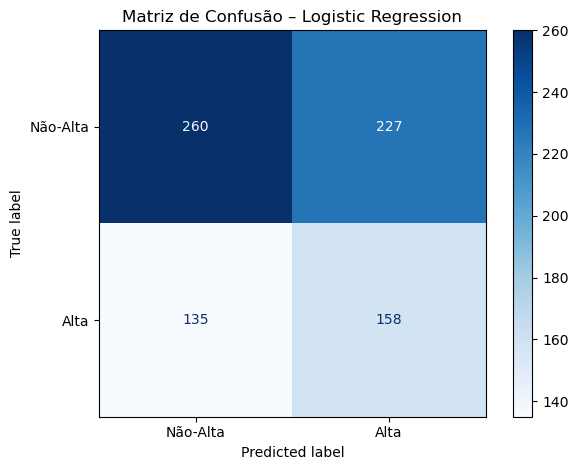

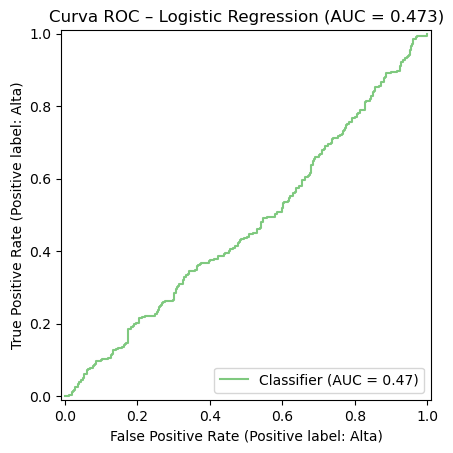

In [33]:
# 1. Criar variável binária
df_customer["Review Binary"] = df_customer["Review Rating"].apply(lambda x: "Alta" if x >= 4.1 else "Não-Alta")

# 2. Separar features e target
X = df_customer[colunas_numericas + colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas]
y = df_customer["Review Binary"]

# 3. Separar treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 4. Pré-processamento
categorical_cols = colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
], remainder="passthrough")

# 5. Pipeline com Logistic Regression
pipe = Pipeline([
    ("preprocessamento", preprocessor),
    ("modelo", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# 6. Treinar modelo
pipe.fit(X_train, y_train)

# 7. Previsões e probabilidades
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]  # Probabilidade da classe "Alta"

# 8. Avaliação
print("📊 Avaliação – Logistic Regression (Balanced)\n")
print(classification_report(y_test, y_pred, digits=3))

# 9. Matriz de Confusão
cm = confusion_matrix(y_test, y_pred, labels=["Não-Alta", "Alta"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Não-Alta", "Alta"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão – Logistic Regression")
plt.tight_layout()
plt.show()

# 10. Curva ROC
auc = roc_auc_score((y_test == "Alta").astype(int), y_prob)
RocCurveDisplay.from_predictions(y_test, y_prob, pos_label="Alta")
plt.title(f"Curva ROC – Logistic Regression (AUC = {auc:.3f})")

plt.savefig(r"C:\Users\Camilo_Bica\data_science\portifolio\customer_shopping\imagens\matriz_confusao.png", dpi=200, bbox_inches='tight')
plt.show()

## DIAGNÓSTICOS INICIAIS (Grupos e Variáveis)

### 1. Avaliação por grupo
(mantém seu bloco de avaliação com avaliar_grupo)
Resultado: AUC/F1 por grupo temático.

### 2. Avaliação de impacto por variável original
(mantém seu bloco com df_coef e impacto_var)
Resultado: quais variáveis individuais mais impactam

In [34]:
# Definir grupos
grupo_cliente = ["Gender", "Age Interval"]
grupo_produto = ["Item Purchased", "Category", "Color", "Size"]
grupo_comportamento = ["Subscription Status", "Frequency of Purchases", "Previous Purchases", "Season"]
grupo_transacao = ["Location", "Shipping Type", "Payment Method", "Discount Applied"]

# Alvo
y = df_customer["Review Binary"]

# Avaliar todos
resultados = []
resultados.append(avaliar_grupo("Cliente", grupo_cliente, df_customer, y))
resultados.append(avaliar_grupo("Produto", grupo_produto, df_customer, y))
resultados.append(avaliar_grupo("Comportamento", grupo_comportamento, df_customer, y))
resultados.append(avaliar_grupo("Transação", grupo_transacao, df_customer, y))

# Mostrar resultados
pd.set_option("display.max_colwidth", None)
df_result = pd.DataFrame(resultados).sort_values("AUC", ascending=False)
display(df_result)

,Grupo,Variáveis,AUC,F1_Alta,Accuracy
0,Cliente,"[Gender, Age Interval]",0.546369,0.421477,0.447436
2,Comportamento,"[Subscription Status, Frequency of Purchases, Previous Purchases, Season]",0.508620,0.420900,0.488462
3,Transação,"[Location, Shipping Type, Payment Method, Discount Applied]",0.493934,0.420896,0.502564
1,Produto,"[Item Purchased, Category, Color, Size]",0.456535,0.460624,0.534615


In [35]:
caminho_modelo_logistico_pipeline_pkl = r"C:\Users\Camilo_Bica\data_science\portifolio\customer_shopping\modelos\modelo_logistico_pipeline.pkl"

pipeline = Pipeline(steps=[
    ("preprocessamento", preprocessor),
    ("modelo", LogisticRegression(max_iter=1000, class_weight="balanced"))
])
pipeline.fit(X_train, y_train)

joblib.dump(pipeline, caminho_modelo_logistico_pipeline_pkl)

['C:\\Users\\Camilo_Bica\\data_science\\portifolio\\customer_shopping\\modelos\\modelo_logistico_pipeline.pkl']

In [36]:
# Extrair modelo e encoder do pipeline
modelo = pipeline.named_steps["modelo"]
ohe = pipeline.named_steps["preprocessamento"].named_transformers_["cat"]

# Lista de colunas categóricas originais
categorical_originais = colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas

# Obter os nomes das features após OneHotEncoding
feature_names = ohe.get_feature_names_out().tolist() + colunas_numericas
coef = modelo.coef_[0]

# Criar DataFrame de coeficientes
df_coef = pd.DataFrame({
    "Feature": feature_names,
    "Coef": coef
})

# Extrair a variável original de cada feature one-hot
df_coef["Variavel_Origem"] = df_coef["Feature"].str.extract(r'^([^\_]+)')  # antes do primeiro underscore
df_coef["AbsCoef"] = df_coef["Coef"].abs()

# Agrupar por variável original
impacto_var = df_coef.groupby("Variavel_Origem").agg(
    Media_Abs_Coef=("AbsCoef", "mean"),
    Max_Abs_Coef=("AbsCoef", "max"),
    Total_Levels=("Feature", "count")
).sort_values("Media_Abs_Coef", ascending=False)

display(impacto_var)

,Media_Abs_Coef,Max_Abs_Coef,Total_Levels
Variavel_Origem,,,
Location,0.191553,0.634424,50
Color,0.161838,0.493892,25
Item Purchased,0.153246,0.379063,25
Size,0.128341,0.179443,4
Gender,0.082341,0.083101,2
Shipping Type,0.072140,0.217180,6
Category,0.063745,0.094338,4
Payment Method,0.062054,0.130305,6
Frequency of Purchases,0.055961,0.102162,7


## 6. Construção de Superfeatures (Super_Combinações)

### 6.1 Diagnóstico Inicial

Antes da criação das superfeatures, foi feita uma análise de impacto individual das variáveis originais com o objetivo de entender quais têm maior influência sobre o `Review Rating`. Os resultados mostraram que nenhuma variável isolada se destaca significativamente.

### 6.2 Por Que Criar Superfeatures?

A criação de **superfeatures** consiste em combinar múltiplas variáveis (numéricas e categóricas) em novas representações que capturam **interações não lineares** ou **relações latentes** que não são visíveis em atributos isolados.

### 6.3 Estratégia Utilizada

- Agrupamentos temáticos de colunas (por exemplo: demográficas, comportamentais).
- Combinações via operações aritméticas, flags binárias, score compostos e encoding customizado.
- Avaliação da nova feature via métricas como **AUC**, **F1** e ganho de informação.

### 6.4 Diagnóstico de Performance

Utilizei um pipeline de validação para avaliar o desempenho das superfeatures na previsão de `Review Rating`. Embora o ganho em explicabilidade seja moderado, elas ajudam a enriquecer o modelo com mais nuances de comportamento do cliente.

> **Nota crítica:** Mesmo com superfeatures, o `Review Rating` continua difícil de prever. Isso reforça a hipótese de que há **fatores externos ao dataset** influenciando a variável.


In [37]:
# Criação das colunas
df_customer["Category_Item_Color"] = df_customer[["Category", "Item Purchased", "Color"]].astype(str).agg("_".join, axis=1)
df_customer["Category_Item_Size"] = df_customer[["Category", "Item Purchased", "Size"]].astype(str).agg("_".join, axis=1)
df_customer["Category_Item_Location"] = df_customer[["Category", "Item Purchased", "Location"]].astype(str).agg("_".join, axis=1)

# Adiciona ao pipeline
colunas_categoricas_nao_ordenadas += [
    "Category_Item_Color",
    "Category_Item_Size",
    "Category_Item_Location"
]

## 7. Modelo Final e Exportação

### 7.1 Construção do Pipeline

Foi construído um pipeline completo integrando:

- Pré-processamento (scaling + encoding)
- Balanceamento de classes com SMOTE
- Modelo preditivo (ex: RandomForestClassifier ou GradientBoostingClassifier)

Esse pipeline permite automatizar o processo desde a entrada dos dados até a previsão da variável-alvo.

### 7.2 Avaliação do Modelo

Métricas utilizadas:

- **F1-score macro:** para avaliar equilíbrio entre classes
- **ROC AUC:** para medir separabilidade geral
- **Matriz de confusão e relatórios de classificação**

Os resultados demonstram que o modelo tem **baixa capacidade preditiva para Review Rating**, validando os achados anteriores sobre limitação dos dados disponíveis.

### 7.3 Exportação para Produção

O pipeline final foi serializado usando `joblib`, permitindo uso futuro sem necessidade de reentreinamento.

```python
import joblib
joblib.dump(modelo_final, 'modelo_review_rating.pkl')


In [38]:
# 1. Atualiza colunas categóricas
categorical_cols = list(dict.fromkeys(
    colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas
))

# 2. Atualiza o pipeline
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
], remainder="passthrough")

pipeline = Pipeline(steps=[
    ("preprocessamento", preprocessor),
    ("modelo", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# 3. Treina o modelo final
X = df_customer[categorical_cols + colunas_numericas]
y = df_customer["Review Binary"]
pipeline.fit(X, y)

# 4. Salva o modelo
joblib.dump(pipeline, caminho_modelo_logistico_pipeline_pkl)

print("✅ Modelo final exportado com sucesso!")

✅ Modelo final exportado com sucesso!


C:\Users\Camilo_Bica\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
# Rodar comparações

variacoes = {
    "Category_Item_Location": ["Category", "Item Purchased", "Location"],
    "Category_Item_Color": ["Category", "Item Purchased", "Color"],
    "Category_Item_Size": ["Category", "Item Purchased", "Size"],
}

resultados = {}

for nome, cols in variacoes.items():
    df_result = avaliar_superfeature(df_customer.copy(), cols, nome, colunas_numericas)
    resultados[nome] = df_result


🔎 Avaliando: Category_Item_Location
➡️ Perfis únicos: 1199
📊 Frequência:
count
3    286
2    268
4    231
1    168
5    134
Name: count, dtype: int64
🎯 AUC: 0.193

🔎 Avaliando: Category_Item_Color
➡️ Perfis únicos: 625
📊 Frequência:
count
6    120
5     91
7     83
4     81
8     53
Name: count, dtype: int64
🎯 AUC: 0.273

🔎 Avaliando: Category_Item_Size
➡️ Perfis únicos: 100
📊 Frequência:
count
39    5
66    5
18    5
41    4
46    4
Name: count, dtype: int64
🎯 AUC: 0.409


In [40]:
# Alvo
y = df_customer["Review Binary"]

# Criar as superfeatures necessárias se ainda não existirem
if "Category_Item_Color" not in df_customer.columns:
    df_customer["Category_Item_Color"] = df_customer[["Category", "Item Purchased", "Color"]].astype(str).agg("_".join, axis=1)

if "Category_Item_Size" not in df_customer.columns:
    df_customer["Category_Item_Size"] = df_customer[["Category", "Item Purchased", "Size"]].astype(str).agg("_".join, axis=1)

if "Category_Item_Location" not in df_customer.columns:
    df_customer["Category_Item_Location"] = df_customer[["Category", "Item Purchased", "Location"]].astype(str).agg("_".join, axis=1)
    
# Rodar diagnósticos
df_color = diagnostico_superfeature(df_customer, "Category_Item_Color", y)
df_size = diagnostico_superfeature(df_customer, "Category_Item_Size", y)
df_location = diagnostico_superfeature(df_customer, "Category_Item_Location", y)


🔎 Analisando: Category_Item_Color

✅ Top 15 - Perfis com maior impacto positivo:


,Perfil,Coef,Freq,AbsCoef
230,Clothing_Dress_Cyan,1.535930,11,1.535930
117,Accessories_Hat_Purple,1.238911,7,1.238911
348,Clothing_Shirt_White,1.238911,7,1.238911
350,Clothing_Shorts_Beige,1.138060,6,1.138060
325,Clothing_Shirt_Beige,1.138060,6,1.138060
308,Clothing_Pants_Green,1.138060,6,1.138060
380,Clothing_Skirt_Cyan,1.138060,6,1.138060
622,Outerwear_Jacket_Violet,1.138060,6,1.138060
19,Accessories_Backpack_Silver,1.138060,6,1.138060
606,Outerwear_Jacket_Gold,1.138060,6,1.138060



🔻 Top 15 - Perfis com maior impacto negativo:


,Perfil,Coef,Freq,AbsCoef
246,Clothing_Dress_Turquoise,-1.250745,4,1.250745
362,Clothing_Shorts_Maroon,-1.246418,7,1.246418
416,Clothing_Socks_Pink,-1.124082,9,1.124082
145,Accessories_Jewelry_Teal,-1.124082,9,1.124082
102,Accessories_Hat_Blue,-1.121769,6,1.121769
73,Accessories_Gloves_White,-1.059605,3,1.059605
479,Footwear_Boots_Charcoal,-1.059605,3,1.059605
141,Accessories_Jewelry_Pink,-1.059605,3,1.059605
190,Accessories_Sunglasses_Peach,-1.059605,3,1.059605
142,Accessories_Jewelry_Purple,-1.059605,3,1.059605



🔎 Analisando: Category_Item_Size

✅ Top 15 - Perfis com maior impacto positivo:


,Perfil,Coef,Freq,AbsCoef
45,Clothing_Jeans_M,0.976369,41,0.976369
46,Clothing_Jeans_S,0.816150,26,0.816150
34,Clothing_Blouse_S,0.754777,29,0.754777
52,Clothing_Shirt_L,0.712941,41,0.712941
29,Accessories_Sunglasses_M,0.552708,73,0.552708
58,Clothing_Shorts_S,0.505452,27,0.505452
38,Clothing_Dress_S,0.505452,27,0.505452
67,Clothing_Socks_XL,0.459202,19,0.459202
89,Footwear_Sneakers_M,0.426999,56,0.426999
4,Accessories_Belt_L,0.419771,39,0.419771



🔻 Top 15 - Perfis com maior impacto negativo:


,Perfil,Coef,Freq,AbsCoef
83,Footwear_Sandals_XL,-1.239177,17,1.239177
75,Clothing_T-shirt_XL,-0.769608,16,0.769608
79,Footwear_Boots_XL,-0.690666,13,0.690666
30,Accessories_Sunglasses_S,-0.513280,36,0.513280
7,Accessories_Belt_XL,-0.475949,19,0.475949
62,Clothing_Skirt_S,-0.468239,27,0.468239
94,Outerwear_Coat_S,-0.414748,36,0.414748
55,Clothing_Shirt_XL,-0.396896,22,0.396896
54,Clothing_Shirt_S,-0.391981,20,0.391981
15,Accessories_Handbag_XL,-0.384862,18,0.384862



🔎 Analisando: Category_Item_Location

✅ Top 15 - Perfis com maior impacto positivo:


,Perfil,Coef,Freq,AbsCoef
1185,Outerwear_Jacket_Oklahoma,1.419405,8,1.419405
393,Clothing_Blouse_Georgia,1.312293,7,1.312293
75,Accessories_Belt_Nevada,1.312293,7,1.312293
412,Clothing_Blouse_New Hampshire,1.312293,7,1.312293
1110,Outerwear_Coat_Florida,1.193774,6,1.193774
1101,Footwear_Sneakers_Wyoming,1.193774,6,1.193774
407,Clothing_Blouse_Mississippi,1.193774,6,1.193774
641,Clothing_Shirt_Louisiana,1.193774,6,1.193774
552,Clothing_Jeans_Montana,1.193774,6,1.193774
154,Accessories_Handbag_Hawaii,1.193774,6,1.193774



🔻 Top 15 - Perfis com maior impacto negativo:


,Perfil,Coef,Freq,AbsCoef
624,Clothing_Shirt_Alabama,-1.494825,5,1.494825
371,Accessories_Sunglasses_Pennsylvania,-1.314990,4,1.314990
170,Accessories_Handbag_Nevada,-1.097080,3,1.097080
191,Accessories_Hat_Alabama,-1.097080,3,1.097080
1120,Outerwear_Coat_Maine,-1.097080,3,1.097080
1027,Footwear_Shoes_Massachusetts,-1.097080,3,1.097080
660,Clothing_Shirt_Pennsylvania,-1.097080,3,1.097080
1093,Footwear_Sneakers_Tennessee,-1.097080,3,1.097080
160,Accessories_Handbag_Louisiana,-1.097080,3,1.097080
1190,Outerwear_Jacket_Tennessee,-1.097080,3,1.097080


In [41]:
from src.score_clientes import pontuar_cliente

# Exemplo de cliente (substitua com dados reais!
cliente_teste = {
    "Item Purchased": "Jeans",
    "Category": "Clothing",
    "Color": "Blue",
    "Location": "California",
    "Size": "S",
    "Gender": "Male",
    "Shipping Type": "Standard",
    "Payment Method": "Credit Card",
    "Discount Applied": 0,
    "Subscription Status": 0,
    "Season": "Spring",
    "Frequency of Purchases": "Occasionally",
    "Previous Purchases": 7,
    "Purchase Amount (USD)": 16.37,
    "Age": 53
}

# Chamar a função
classe, probabilidade = pontuar_cliente(cliente_teste)

📌 Classe Prevista: Não-Alta
📈 Probabilidade de ser 'Alta': 20.84%


In [42]:
# Caminhos
caminho_csv = r"C:\Users\Camilo_Bica\data_science\portifolio\customer_shopping\dados\clientes_ficticios.csv"
caminho_saida = r"C:\Users\Camilo_Bica\data_science\portifolio\customer_shopping\resultados\clientes_com_score.csv"

# Garantir que a pasta de saída exista
os.makedirs(os.path.dirname(caminho_saida), exist_ok=True)

# Carregar dados
df_clientes = pd.read_csv(caminho_csv)

# Criar superfeatures esperadas pelo pipeline
df_clientes["Category_Item_Color"] = df_clientes[["Category", "Item Purchased", "Color"]].astype(str).agg("_".join, axis=1)
df_clientes["Category_Item_Size"] = df_clientes[["Category", "Item Purchased", "Size"]].astype(str).agg("_".join, axis=1)
df_clientes["Category_Item_Location"] = df_clientes[["Category", "Item Purchased", "Location"]].astype(str).agg("_".join, axis=1)

# Carregar pipeline treinado
pipeline = joblib.load(caminho_modelo_logistico_pipeline_pkl)

# Obter índice da classe "Alta" com segurança
idx_alta = np.where(pipeline.classes_ == "Alta")[0][0]

# Prever probabilidade da classe 'Alta'
probs = pipeline.predict_proba(df_clientes)
df_clientes["Prob Alta (%)"] = (probs[:, idx_alta] * 100).round(2)

# Definir classe com base no maior valor de probabilidade
df_clientes["Classe Prevista"] = pipeline.predict(df_clientes)

# Classificação do risco com base na probabilidade
def classificar_probabilidade(prob):
    if prob >= 70:
        return "Alta probabilidade"
    elif prob >= 50:
        return "Moderada"
    else:
        return "Baixa"

df_clientes["Risco de Review"] = df_clientes["Prob Alta (%)"].apply(classificar_probabilidade)

# Salvar resultado
df_clientes.to_csv(caminho_saida, index=False)

print("✅ Scoring finalizado com sucesso!")
print("📁 Arquivo salvo em:", caminho_saida)


✅ Scoring finalizado com sucesso!
📁 Arquivo salvo em: C:\Users\Camilo_Bica\data_science\portifolio\customer_shopping\resultados\clientes_com_score.csv


## 8. Conclusões

- As variáveis disponíveis não explicam bem a avaliação dos clientes (`Review Rating`), indicando a importância de dados subjetivos e qualitativos.
- A clusterização permitiu descobrir **padrões ocultos** e definir **estratégias orientadas por dados** para cada perfil de cliente.
- O uso de superfeatures, estatísticas descritivas e redução de dimensionalidade foram fundamentais para construir os argumentos necessários à análise, mesmo diante da limitação de variáveis explicativas no dataset — reforçando a importância de uma abordagem robusta e multidimensional na ciência de dados aplicada ao comportamento do consumidor.